In [1]:
import pybullet_envs
from gym import make
import numpy as np
import torch
from torch import nn
from torch.distributions import Normal
from torch.nn import functional as F
from torch.optim import Adam
import random
from itertools import product
import joblib
from os import makedirs
import uuid
from train import *
import json
from joblib import Parallel, delayed
from matplotlib import pyplot as plt
from itertools import combinations, product, permutations
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")
from utils.logger import Logger

from train import *

In [2]:
def run(env_name="AntBulletEnv-v0", 
        transitions=1000000, 
        eps=0.2, 
        gamma=0.99, 
        tau=0.002, 
        actor_lr=2e-4, 
        critic_lr=5e-4, 
        sigma=2, 
        c=1, 
        updates_number=1, 
        policy_delay=1, 
        batch_size=128,
        buffer_size=200000,
        start_training=None,
        evaluate_every=None,
        seed=42):
    start_training = start_training if start_training else buffer_size // 10
    evaluate_every = evaluate_every if evaluate_every else transitions // 100
    
    logger = Logger(locals())

    makedirs("experiments", exist_ok=True)
    saved_agent_dir = "experiments/" + str(uuid.uuid4()) + "/"
    makedirs(saved_agent_dir)

    logger.save_params(saved_agent_dir + "params.json")

    env = make(env_name)
    test_env = make(env_name)
    
    td3 = TD3(state_dim=env.observation_space.shape[0], 
              action_dim=env.action_space.shape[0], 
              actor_lr=actor_lr, critic_lr=critic_lr,
              buffer_size=buffer_size)

    state = env.reset()
    episodes_sampled = 0
    steps_sampled = 0
    
    set_seed(env, seed=seed)

    t = tqdm(range(transitions))

    for i in t:
        if i > start_training:
            action = td3.act(state)
            action = np.clip(action + eps * np.random.randn(*action.shape), -1, +1)

            next_state, reward, done, _ = env.step(action)

            td3.update((state, action, next_state, reward, done), 
                        sigma=sigma, c=c, updates_number=updates_number, policy_delay=policy_delay,
                        batch_size=batch_size, gamma=gamma, tau= tau)
        else:
            action = np.random.uniform(-1, 1, size=env.action_space.shape)
            next_state, reward, done, _ = env.step(action)
            td3.replay_buffer.append((state, action, next_state, reward, done))

        state = env.reset() if done else next_state
        
        if (i + 1) % evaluate_every == 0:
            rewards = evaluate_policy(test_env, td3, 5, seed=seed)
            rmean = np.mean(rewards)
            rstd = np.std(rewards)

            logger.log("step", i + 1)
            logger.log("rmean", rmean)
            logger.log("rstd", rstd)
            logger.save(saved_agent_dir + "log.csv")
            
            if rmean > 2500:
                td3.save(name=f"{saved_agent_dir}/{i + 1}_{int(rmean)}_{int(rstd)}.pkl")

            t.set_description(f"{rmean:0.2f} | {rstd:0.2f}")

    return logger

drun = delayed(run)

  0%|          | 0/1000000 [00:00<?, ?it/s]

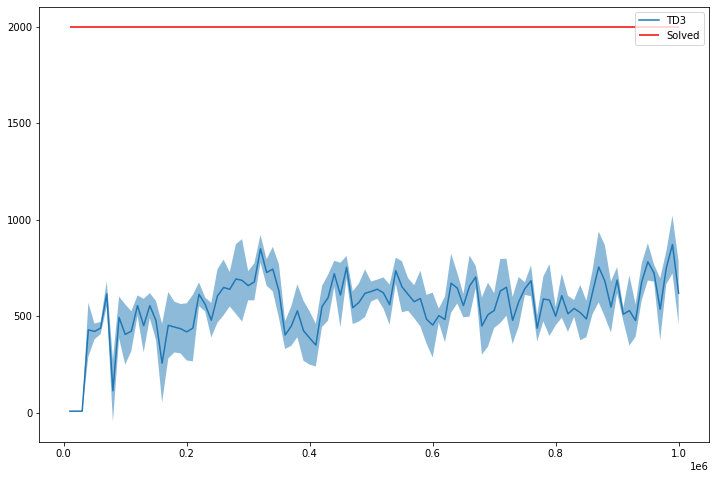

In [3]:
base_config = {
    "transitions": 1_000_000,
    "eps": 0.1,
    "gamma": 0.99,
    "tau": 0.002,
    "actor_lr": 2e-4,
    "critic_lr": 5e-4,
    "sigma": np.sqrt(2),
    "c": 0.5,
    "updates_number": 1,
    "policy_delay": 1,
    "batch_size": 2048,
    "buffer_size": 200_000,
    "start_training": -1,
    "evaluate_every": None,
}

run(**base_config).plot("step", "rmean", "rstd", label="TD3", y_solved=2000)

In [4]:
# blacklist = [
#     {
#         "transitions": 1500000,
#         "eps": 0.2,
#         "gamma": 0.999,
#         "tau": 0.001,
#         "actor_lr": 0.0001,
#         "critic_lr": 0.0002,
#         "sigma": 2,
#         "c": 2,
#         "updates_number": 1,
#         "policy_delay": 4,
#         "batch_size": 64,
#         "start_training": 20000
#     },
#     {
#         "transitions": 1500000,
#         "eps": 0.2,
#         "gamma": 0.999,
#         "tau": 0.001,
#         "actor_lr": 0.0001,
#         "critic_lr": 0.0002,
#         "sigma": 2,
#         "c": 2,
#         "updates_number": 1,
#         "policy_delay": 1,
#         "batch_size": 64,
#         "start_training": 20000
#     },
#     {
#         "transitions": 1500000,
#         "eps": 0.2,
#         "gamma": 0.999,
#         "tau": 0.001,
#         "actor_lr": 0.0001,
#         "critic_lr": 0.0002,
#         "sigma": 2,
#         "c": 2,
#         "updates_number": 1,
#         "policy_delay": 1,
#         "batch_size": 128,
#         "start_training": 20000
#     },
#     {
#         "transitions": 1500000,
#         "eps": 0.2,
#         "gamma": 0.999,
#         "tau": 0.001,
#         "actor_lr": 0.0001,
#         "critic_lr": 0.0002,
#         "sigma": 2,
#         "c": 2,
#         "updates_number": 1,
#         "policy_delay": 2,
#         "batch_size": 64,
#         "start_training": 20000
#     },
#     {
#         "transitions": 1500000,
#         "eps": 0.2,
#         "gamma": 0.999,
#         "tau": 0.001,
#         "actor_lr": 0.0001,
#         "critic_lr": 0.0002,
#         "sigma": 2,
#         "c": 2,
#         "updates_number": 1,
#         "policy_delay": 8,
#         "batch_size": 64,
#         "start_training": 20000
#     }
    



# ]

In [5]:
# configs = []

# params = product(
#     (1_500_000,),    # transitions
#     (0.2, 0.5, 1),      # eps
#     (0.999, 0.99),   # gamma
#     (1e-3, 1e-2),    # tau
#     (1e-4, 1e-3),    # actor lr
#     (2e-4, 2e-3),    # critic lr
#     (2, 1, 0.5),     # sigma
#     (2, 1, 0.5),     # c
#     (1, 2, 4, 8),    # number of updates
#     (1, 2, 4, 8),    # policy delay
#     (64, 128, 256),  # batch size
# )

# for tramsitions, eps, gamma, tau, actor_lr, critic_lr, sigma, c, updates_number, policy_delay, batch_size in params:
#     cfg = {
#         "transitions": tramsitions,
#         "eps": eps,
#         "gamma": gamma,
#         "tau": tau,
#         "actor_lr": actor_lr,
#         "critic_lr": critic_lr,
#         "sigma": sigma,
#         "c": c,
#         "updates_number": updates_number,
#         "policy_delay": policy_delay,
#         "batch_size": batch_size
#     }
    
#     if cfg not in blacklist:
#         configs.append(cfg)

# print(len(configs))

In [6]:
# logs = Parallel(n_jobs=5)(drun(**cfg) for cfg in tqdm(configs))
# for log in logs:
#     plot(log)

In [7]:
# trans_num = 10_000_000
# to_check = [
#     {
#         "transitions": trans_num,
#         "eps": 0.2,
#         "gamma": 0.999,
#         "tau": 0.001,
#         "actor_lr": 0.0001,
#         "critic_lr": 0.0002,
#         "sigma": 2,
#         "c": 2,
#         "updates_number": 1,
#         "policy_delay": 2,
#         "batch_size": 128,
#         "start_training": 20000
#     },
#         {
#         "transitions": trans_num,
#         "eps": 0.2,
#         "gamma": 0.999,
#         "tau": 0.001,
#         "actor_lr": 0.0001,
#         "critic_lr": 0.0002,
#         "sigma": 2,
#         "c": 2,
#         "updates_number": 1,
#         "policy_delay": 1,
#         "batch_size": 256,
#         "start_training": 20000
#     },
#     {
#         "transitions": trans_num,
#         "eps": 0.2,
#         "gamma": 0.999,
#         "tau": 0.001,
#         "actor_lr": 0.0001,
#         "critic_lr": 0.0002,
#         "sigma": 2,
#         "c": 2,
#         "updates_number": 1,
#         "policy_delay": 4,
#         "batch_size": 64,
#         "start_training": 20000
#     },
#     {
#         "transitions": trans_num,
#         "eps": 0.2,
#         "gamma": 0.999,
#         "tau": 0.001,
#         "actor_lr": 0.0001,
#         "critic_lr": 0.0002,
#         "sigma": 2,
#         "c": 2,
#         "updates_number": 1,
#         "policy_delay": 4,
#         "batch_size": 256,
#         "start_training": 20000
#     },
#     {
#         "transitions": trans_num,
#         "eps": 0.2,
#         "gamma": 0.999,
#         "tau": 0.001,
#         "actor_lr": 0.0001,
#         "critic_lr": 0.0002,
#         "sigma": 2,
#         "c": 2,
#         "updates_number": 1,
#         "policy_delay": 2,
#         "batch_size": 256,
#         "start_training": 20000
#     },
#     {
#         "transitions": trans_num,
#         "eps": 0.2,
#         "gamma": 0.999,
#         "tau": 0.001,
#         "actor_lr": 0.0001,
#         "critic_lr": 0.0002,
#         "sigma": 2,
#         "c": 2,
#         "updates_number": 1,
#         "policy_delay": 2,
#         "batch_size": 256,
#         "start_training": 20000
#     }
# ]

In [8]:
# logs = Parallel(n_jobs=6)(drun(**cfg) for cfg in tqdm(to_check))
# for log in logs:
#     plot(log)